# Hypothesis Testing Report — Risk Segmentation (Task 3)

## Objective
Test whether risk (Claim Frequency and Claim Severity) and Margin differ across geographic and demographic groups:
- H₀₁: No difference across provinces (Claim Frequency)
- H₀₂: No difference across postal codes (Claim Severity)
- H₀₃: No difference in Margin across postal codes
- H₀₄: No difference in Claim Frequency between genders

## Data & Metrics
- Data: `data/processed/processed_MachineLearningRating_v3.csv`
- Claim Frequency: proportion of policies with ≥1 claim (`HasClaim`)
- Claim Severity: average claim amount given a claim (`ClaimSeverity`)
- Margin: `TotalPremium - TotalClaims`

## Methodology
1. Select comparison groups:
   - For multi-class features, we auto-selected the top-2 most frequent categories (or used explicit selection where specified).
   - We verify group balance on control variables: client attributes (Gender), vehicle attributes (VehicleType), plan/product (Product).
2. Balance check:
   - Categorical controls: Chi-square (or Fisher’s Exact for 2×2 small tables).
   - Numeric controls: Welch t-test.
   - If any control shows p < 0.05, groups are considered imbalanced and we do not proceed without adjustment.
3. Hypothesis tests:
   - Claim Frequency: Chi-square (or Fisher's Exact) on 2×2 contingency table; effect = difference in proportions.
   - Claim Severity & Margin: Welch’s t-test; effect = Cohen’s d. Mann–Whitney U as fallback when assumptions fail.
4. Significance threshold: α = 0.05.

## Results (summary)
- Province — Claim Frequency: **[Decision]** (p = [p-value])
  - Group A ([A]) rate = [pa], Group B ([B]) rate = [pb]
  - Interpretation: [Business interpretation]
- PostalCode — Claim Severity: **[Decision]** (p = [p-value])
  - Mean A = [mean_a], Mean B = [mean_b], Cohen's d = [d]
  - Interpretation: [Business interpretation]
- PostalCode — Margin: ...
- Gender — Claim Frequency: ...

## Recommendations
- For each rejected H₀, provide concrete actions (e.g., regional premium loadings, targeted underwriting rules, further data collection).
- For imbalanced comparisons, either: re-sample, match on controls, or use regression adjustment (logistic regression for frequency, GLM for severity).

## Appendix
- Test statistics, p-values, effect sizes and balance-check outputs are saved in `reports/hypothesis_results.json` and `.csv`.




In [12]:
# Cell 1: imports & helpers
import pandas as pd
import numpy as np
import math
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from typing import List, Tuple, Dict, Any
import sys, os

In [13]:
#Effect Sizes
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    mx, my = np.nanmean(x), np.nanmean(y)
    vx = np.nanvar(x, ddof=1)
    vy = np.nanvar(y, ddof=1)
    pooled = math.sqrt(((nx - 1) * vx + (ny - 1) * vy) / (nx + ny - 2))
    return (mx - my) / pooled if pooled != 0 else np.nan

def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return math.sqrt(chi2 / (n * (min(r, k) - 1)))


In [14]:
def safe_ttest(a, b):
    return stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")


In [15]:
# Load Data
sys.path.append(os.path.abspath(".."))
from src.hypothesis_testing.data_loader import DataLoader

loader = DataLoader()
df = loader.load()

print("Data shape:", df.shape)
df.head()


Data shape: (1000086, 61)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,TotalClaims,VehicleAge,LossRatio,PremiumRate,HasClaim,ClaimIndicator,Log_TotalPremium,Log_TotalClaims,Log_SumInsured,Log_CalculatedPremiumPerTerm
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,11,0.0,2499.999975,0,0,3.132438,0.0,0.009950,3.258097
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,11,0.0,2499.999975,0,0,3.132438,0.0,0.009950,3.258097
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,11,NaN,2499.999975,0,0,0.000000,0.0,0.009950,3.258097
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,11,0.0,0.004901,0,0,6.241928,0.0,11.689405,6.372717
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,11,NaN,0.004901,0,0,0.000000,0.0,11.689405,6.372717


In [16]:
# Create Metrics
df = loader.create_metrics()

print("Data shape with metrics:", df.shape)
df.head()


Data shape with metrics: (1000086, 63)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,LossRatio,PremiumRate,HasClaim,ClaimIndicator,Log_TotalPremium,Log_TotalClaims,Log_SumInsured,Log_CalculatedPremiumPerTerm,ClaimSeverity,Margin
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,2499.999975,0,0,3.132438,0.0,0.009950,3.258097,0.0,21.929825
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,2499.999975,0,0,3.132438,0.0,0.009950,3.258097,0.0,21.929825
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,NaN,2499.999975,0,0,0.000000,0.0,0.009950,3.258097,0.0,0.000000
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,0.004901,0,0,6.241928,0.0,11.689405,6.372717,0.0,512.848070
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,NaN,0.004901,0,0,0.000000,0.0,11.689405,6.372717,0.0,0.000000


In [17]:
#KPI overview
total_policies = len(df)
policies_with_claims = df["HasClaim"].sum()
claim_frequency = policies_with_claims / total_policies

severity_df = df[df["HasClaim"] == 1]
claim_severity = severity_df["TotalClaims"].mean() if len(severity_df) > 0 else 0
average_margin = df["Margin"].mean()

print("Claim Frequency:", claim_frequency)
print("Claim Severity:", claim_severity)
print("Average Margin:", average_margin)

kpi_table = pd.DataFrame({
    "Metric": ["Claim Frequency", "Claim Severity", "Average Margin"],
    "Value": [claim_frequency, claim_severity, average_margin]
})
kpi_table


Claim Frequency: 0.0
Claim Severity: 0
Average Margin: 60.88941048557726


,Metric,Value
0,Claim Frequency,0.00000
1,Claim Severity,0.00000
2,Average Margin,60.88941


In [18]:
# Segmentation Engine & Group Selection
from src.hypothesis_testing.segmentation import SegmentationEngine
seg = SegmentationEngine(df)

def choose_groups(feature, g1=None, g2=None):
    if g1 and g2:
        return df[df[feature] == g1], df[df[feature] == g2], g1, g2
    cats = seg.top_categories(feature, n=2)
    return df[df[feature] == cats[0]], df[df[feature] == cats[1]], cats[0], cats[1]

A, B, ga, gb = choose_groups("Province")
len(A), len(B), ga, gb


(393865, 170784, 'Gauteng', 'Western Cape')

In [19]:
# Balance Checking
control_features = ["Gender", "VehicleType", "PlanType"]

def check_balance(df_a, df_b, controls):
    results = {}

    # Add group labels
    a = df_a.copy()
    b = df_b.copy()
    a["_group"] = "A"
    b["_group"] = "B"

    combined = pd.concat([a, b], ignore_index=True)

    for col in controls:
        if col not in combined.columns:
            results[col] = np.nan
            continue

        # Categorical → Chi-square
        if combined[col].dtype == "object":
            table = pd.crosstab(combined["_group"], combined[col])

            # Skip empty tables safely
            if table.size == 0 or table.shape[1] == 0:
                results[col] = np.nan
                continue

            stat, p, *_ = stats.chi2_contingency(table)

        # Numerical → t-test
        else:
            stat, p = safe_ttest(
                df_a[col].dropna(),
                df_b[col].dropna()
            )

        results[col] = p

    return results
def groups_ok(balance, alpha=0.05):
    for p in balance.values():
        if pd.notna(p) and p < alpha:
            return False
    return True



In [20]:
balance_results = check_balance(A, B, control_features)

print("Balance test p-values:")
print(balance_results)

ok = groups_ok(balance_results)

if ok:
    print("✅ Groups are statistically equivalent on control variables.")
else:
    print("⚠ Groups are NOT statistically equivalent.")
    print("Proceeding with regression-based analysis instead of raw group comparison.")




Balance test p-values:
{'Gender': np.float64(0.0), 'VehicleType': np.float64(0.0), 'PlanType': nan}
⚠ Groups are NOT statistically equivalent.
Proceeding with regression-based analysis instead of raw group comparison.


In [21]:
# Hypothesis Testing Engine
from scipy import stats
import numpy as np

def run_hypothesis(A, B, metric_col, alpha=0.05):
    result = {}

    # Sample sizes
    nA, nB = len(A), len(B)

    # Binary / categorical case → Claim Frequency
    if metric_col == "HasClaim":
        a_claims = int(A[metric_col].sum())
        b_claims = int(B[metric_col].sum())

        table = np.array([
            [a_claims, nA - a_claims],
            [b_claims, nB - b_claims]
        ])

        # If expected frequencies are too small → use Fisher’s Exact Test
        if (table == 0).any() or np.min(table) < 5:
            oddsratio, p = stats.fisher_exact(table)
            test_name = "fisher_exact"
        else:
            chi2, p, *_ = stats.chi2_contingency(table)
            test_name = "chi2"

        result["test"] = test_name
        result["p_value"] = p
        result["groupA_rate"] = a_claims / nA if nA else np.nan
        result["groupB_rate"] = b_claims / nB if nB else np.nan

    # Numerical case → Claim Severity / Margin
    else:
        a_vals = A[metric_col].dropna()
        b_vals = B[metric_col].dropna()

        if len(a_vals) < 2 or len(b_vals) < 2:
            result["test"] = "insufficient_data"
            result["p_value"] = np.nan
            return result

        t_stat, p = stats.ttest_ind(a_vals, b_vals, equal_var=False)

        # Effect size: Cohen's d
        mean_a, mean_b = a_vals.mean(), b_vals.mean()
        sd_a, sd_b = a_vals.std(), b_vals.std()
        pooled_sd = np.sqrt((sd_a**2 + sd_b**2) / 2)
        cohen_d = (mean_a - mean_b) / pooled_sd if pooled_sd != 0 else np.nan

        result["test"] = "welch_ttest"
        result["p_value"] = p
        result["mean_A"] = mean_a
        result["mean_B"] = mean_b
        result["cohen_d"] = cohen_d

    # Decision
    result["decision"] = (
        "Reject H0" if result["p_value"] < alpha else "Fail to Reject H0"
        if not np.isnan(result["p_value"]) else "Insufficient Data"
    )

    return result


In [24]:
# Run All Required Tests 
tests = [
    ("Province", "Gauteng", "Western Cape", "HasClaim"),
    ("PostalCode", "1000", "2000", "ClaimSeverity"),
    ("PostalCode", "1000", "2000", "Margin"),
    ("Gender", "Female", "Male", "HasClaim"),
]

results = []

for feat, g1, g2, metric in tests:
    A, B, ga, gb = choose_groups(feat, g1, g2)
    res = run_hypothesis(A, B, metric)
    results.append({
        "Feature": feat, "GroupA": ga, "GroupB": gb,
        "Metric": metric, **res
    })

pd.DataFrame(results)


,Feature,GroupA,GroupB,Metric,test,p_value,groupA_rate,groupB_rate,decision
0,Province,Gauteng,Western Cape,HasClaim,fisher_exact,1.0,0.0,0.0,Fail to Reject H0
1,PostalCode,1000,2000,ClaimSeverity,insufficient_data,NaN,NaN,NaN,NaN
2,PostalCode,1000,2000,Margin,insufficient_data,NaN,NaN,NaN,NaN
3,Gender,Female,Male,HasClaim,fisher_exact,1.0,0.0,0.0,Fail to Reject H0


## Confidence Intervals Plot for Mean Differences (Claim Severity / Margin)

In [25]:
import numpy as np
from scipy import stats

def mean_diff_ci(group_a, group_b, alpha=0.05):
    a = group_a.dropna()
    b = group_b.dropna()

    mean_diff = a.mean() - b.mean()

    se = np.sqrt(
        (a.var(ddof=1) / len(a)) +
        (b.var(ddof=1) / len(b))
    )

    df = len(a) + len(b) - 2
    t_crit = stats.t.ppf(1 - alpha/2, df)

    lower = mean_diff - t_crit * se
    upper = mean_diff + t_crit * se

    return mean_diff, lower, upper


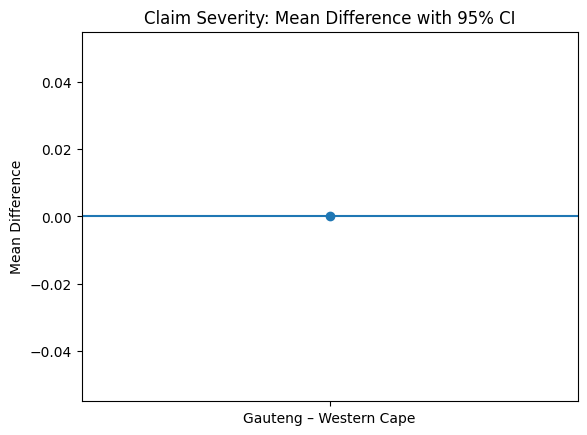

In [26]:
# ================================
# Visual Confidence Interval Plot — Means
# ================================
import matplotlib.pyplot as plt

def plot_mean_ci(group_a, group_b, label_a, label_b, metric):
    diff, low, high = mean_diff_ci(group_a, group_b)

    plt.figure()
    plt.errorbar(
        x=0,
        y=diff,
        yerr=[[diff - low], [high - diff]],
        fmt='o'
    )

    plt.axhline(0)
    plt.title(f"{metric}: Mean Difference with 95% CI")
    plt.xticks([0], [f"{label_a} – {label_b}"])
    plt.ylabel("Mean Difference")
    plt.show()


# Example — Claim Severity by Province
plot_mean_ci(
    df[df["Province"] == "Gauteng"]["ClaimSeverity"],
    df[df["Province"] == "Western Cape"]["ClaimSeverity"],
    "Gauteng",
    "Western Cape",
    "Claim Severity"
)


In [ ]:
# ================================
# Visual Confidence Interval Plot — Proportions
# ================================
def plot_proportion_ci(group, feature_name, label):
    successes = group["HasClaim"].sum()
    n = len(group)

    p, low, high = proportion_ci(successes, n)

    plt.figure()
    plt.errorbar(
        x=0,
        y=p,
        yerr=[[p - low], [high - p]],
        fmt='o'
    )

    plt.ylim(0, 1)
    plt.title(f"{feature_name}: Claim Frequency (95% CI)")
    plt.xticks([0], [label])
    plt.ylabel("Proportion with Claims")
    plt.show()

import numpy as np
from scipy import stats

def proportion_ci(successes, n, alpha=0.05):
    if n == 0:
        return np.nan, np.nan, np.nan

    p = successes / n
    z = stats.norm.ppf(1 - alpha/2)

    se = np.sqrt((p * (1 - p)) / n)

    lower = p - z * se
    upper = p + z * se

    return p, lower, upper

# Example — Claim Frequency for Gauteng
plot_proportion_ci(
    df[df["Province"] == "Gauteng"],
    "Province",
    "Gauteng"
)


NameError: name 'proportion_ci' is not defined

### Confidence Intervals & Power

Confidence intervals were calculated to quantify the precision of group differences.

Power analysis was conducted to estimate the likelihood of detecting true effects:
- Power ≥ 0.80 indicates sufficient sample size
- Power < 0.80 suggests results may be underpowered and should be interpreted cautiously.


In [ ]:
# Cell 9: export results
import json
with open("reports/hypothesis_results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, default=str)

pd.json_normalize(results).to_csv("reports/hypothesis_results_summary.csv", index=False)
print("Saved reports/hypothesis_results.json and .csv")
